In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Efficient sampling with Laplace priors

### Chao Zhang (chaz@dtu.dk)
In this notebook, we explore methods for efficient sampling in solving inverse problems with Laplace priors. The Laplace distribution is important in situations where the signal exhibits heavy tails or where outliers are more frequent than would be expected under a Gaussian distribution. It is also closely related to the LASSO (Least Absolute Shrinkage and Selection Operator) method in optimization that is used to induce sparsity in signals.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi
from cuqi.distribution import Gaussian, JointDistribution

## 1. Introduction

### Difficulty with Laplace priors

The probability density function of a Laplace distribution is of form
$$p(x|\mu, b)\propto\exp(-\frac{|x-\mu|}{b}),$$
where $\mu$ is the mean and $b$ is the scale. The density function is not differentiable arround $\mu$, and this is not desirable since it keeps us from using gradient-based samplers.

### A remedy

To overcome this issue, a remedy would be to "smooth" the Laplace distribution by introducing a smoothing parameter $\epsilon>0$ and the density function becomes
$$p(x|\mu, b)\propto\exp(-\frac{\sqrt{(x-\mu)^2 + \epsilon}}{b}).$$

In doing so, we can make the density function differentiable at $\mu$ and thus we can use gradient-based samplers.

In CUQIpy, we can define such a smoothed Laplace distribution by subclassing `cuqi.distribution.Laplace` where we overwrite the `logpdf` and `gradient` methods. 

In [3]:
class LaplaceSmoothed(cuqi.distribution.Laplace):
    def __init__(self, beta, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta
  
    def logpdf(self, x):
        if isinstance(x, (float,int)):
            x = np.array([x])
        return self.dim*(np.log(0.5/self.scale)) - np.sum(np.sqrt((x-self.location)**2+self.beta))/self.scale

    def gradient(self, val):
        if isinstance(val, (float,int)):
            val = np.array([val])
        return -np.array((val - self.location)/self.scale/np.sqrt((val-self.location)**2+self.beta))

## 2. Verification of implementation

We will verfiy the correctness of our implementation in the following two aspect: function evaluation and statistical properties of the drawn samples.

### `logpdf` and `gradient`
We will compare the `logpdf` and `gradient` of the `smoothed` Laplace against the Laplace distribution. We can see from the following plots that with $\beta=10^{-3}$, the `smoothed` Laplace approximates well the Laplace distribution in both `logpdf` and `gradient`.

/var/folders/6l/nx63qk9s1l7gst1rbgdfb5vc0000gp/T/ipykernel_71016/1877173770.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  laplace_pdf_values[i] = laplace.logpdf(x[i])
/var/folders/6l/nx63qk9s1l7gst1rbgdfb5vc0000gp/T/ipykernel_71016/1877173770.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothed_laplace_grad_values[i] = smoothed_laplace.gradient(x[i])
/var/folders/6l/nx63qk9s1l7gst1rbgdfb5vc0000gp/T/ipykernel_71016/1877173770.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation

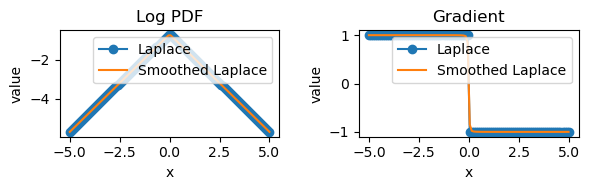

In [4]:
laplace = cuqi.distribution.Laplace(np.array([0]), np.array([1]))
smoothed_laplace = LaplaceSmoothed(location = np.array([0]), scale=1, beta=1e-3)
x = np.linspace(-5, 5, 100)
smoothed_laplace_pdf_values = np.zeros(x.shape)
laplace_pdf_values = np.zeros(x.shape)
smoothed_laplace_grad_values = np.zeros(x.shape)
laplace_grad_values = np.zeros(x.shape)
dx = 1e-4
for i in range(len(x)):
    smoothed_laplace_pdf_values[i] = smoothed_laplace.logpdf(x[i])
    laplace_pdf_values[i] = laplace.logpdf(x[i])
    smoothed_laplace_grad_values[i] = smoothed_laplace.gradient(x[i])
    laplace_grad_values[i] = (laplace.logpdf(x[i])-laplace.logpdf(x[i]-dx))/dx

plt.figure(figsize = (6,2))
plt.subplot(1,2,1)
plt.plot(x, laplace_pdf_values, '-o', label='Laplace')
plt.plot(x, smoothed_laplace_pdf_values, label='Smoothed Laplace')
plt.xlabel('x')
plt.ylabel('value')
plt.title('Log PDF')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.plot(x, laplace_grad_values, '-o', label='Laplace')
plt.plot(x, smoothed_laplace_grad_values, label='Smoothed Laplace')
plt.xlabel('x')
plt.ylabel('value')
plt.title('Gradient')
plt.legend(loc='upper right')
plt.tight_layout()


### Drawing samples from Laplace with NUTS

Since the smoothed Laplace distribution is equipped with a `gradient` method, we can efficiently draw samples from this distribution with a gradient-based sampler. Here we choose NUTS, and the histogram of the samples is also plotted. As comparison, histogram of samples from and the density function of the Laplace distribution are also shown. We can see the samples from the smoothed Laplace distribution mimic the Laplace distribution quite well.

Sample 22000 / 22000


(-10.0, 10.0)

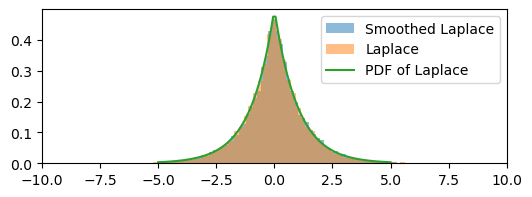

In [5]:
simple_nuts = cuqi.sampler.NUTS(smoothed_laplace)
simple_nuts_samples = simple_nuts.sample(20000, 2000)
plt.figure(figsize=(6,2))
plt.hist(simple_nuts_samples.samples.flatten(), bins=100, density=True, alpha=0.5, label='Smoothed Laplace');
exact_laplace_samples = laplace.sample(20000)
plt.hist(exact_laplace_samples.samples.flatten(), bins=100, density=True, alpha=0.5, label='Laplace');
plt.plot(x, np.exp(laplace_pdf_values), label='PDF of Laplace')
plt.legend()
plt.xlim(-10, 10)

## 3. Application in deconvolution problem

### Forward problem and measurement data

To demonstrate the use of the smoothed Laplace prior, we take the 1D deconvolution test case as example here:

$$y = Ax + \epsilon ,$$
where $y$ is the measurement, $A$ is the convolution operator, $x$ is the input signal and $\epsilon$ is the measurement error. We assume that $x$ is a random variable and it follows a (smoothed) Laplace distribution and the $\epsilon$ is a vector of i.i.d. Gausian random variables.

We will extract $A$ and $y_\text{data}$ directly from `cuqi.testproblem`:

Continuous1D(128,)


Text(0.5, 1.0, 'Data')

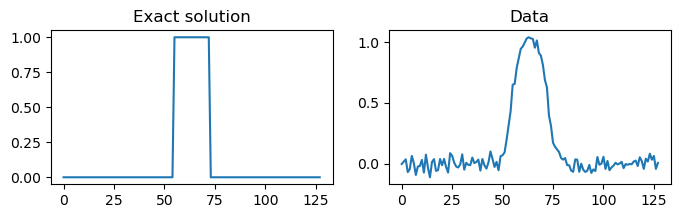

In [6]:
phantom = 'square'
n = 128
noise_std = 0.05
A, y_data, info = cuqi.testproblem.Deconvolution1D(dim=n, phantom=phantom, noise_std = noise_std, PSF_param = 3).get_components()

print(A.domain_geometry)

plt.figure(figsize = (6,2))
plt.subplot(1,2,1)
info.exactSolution.plot()
plt.title("Exact solution")

plt.subplot(1,2,2)
y_data.plot()
plt.title("Data")

### Posterior sampling

Since the smooothed Laplace prior is now implemented with a gradient method, we can use the gradient based samplers, like NUTS, to sample from the posterior distribution. The use of NUTS is quite straightforward as follows:

Sample 8000 / 8000
Selecting 5 randomly chosen variables


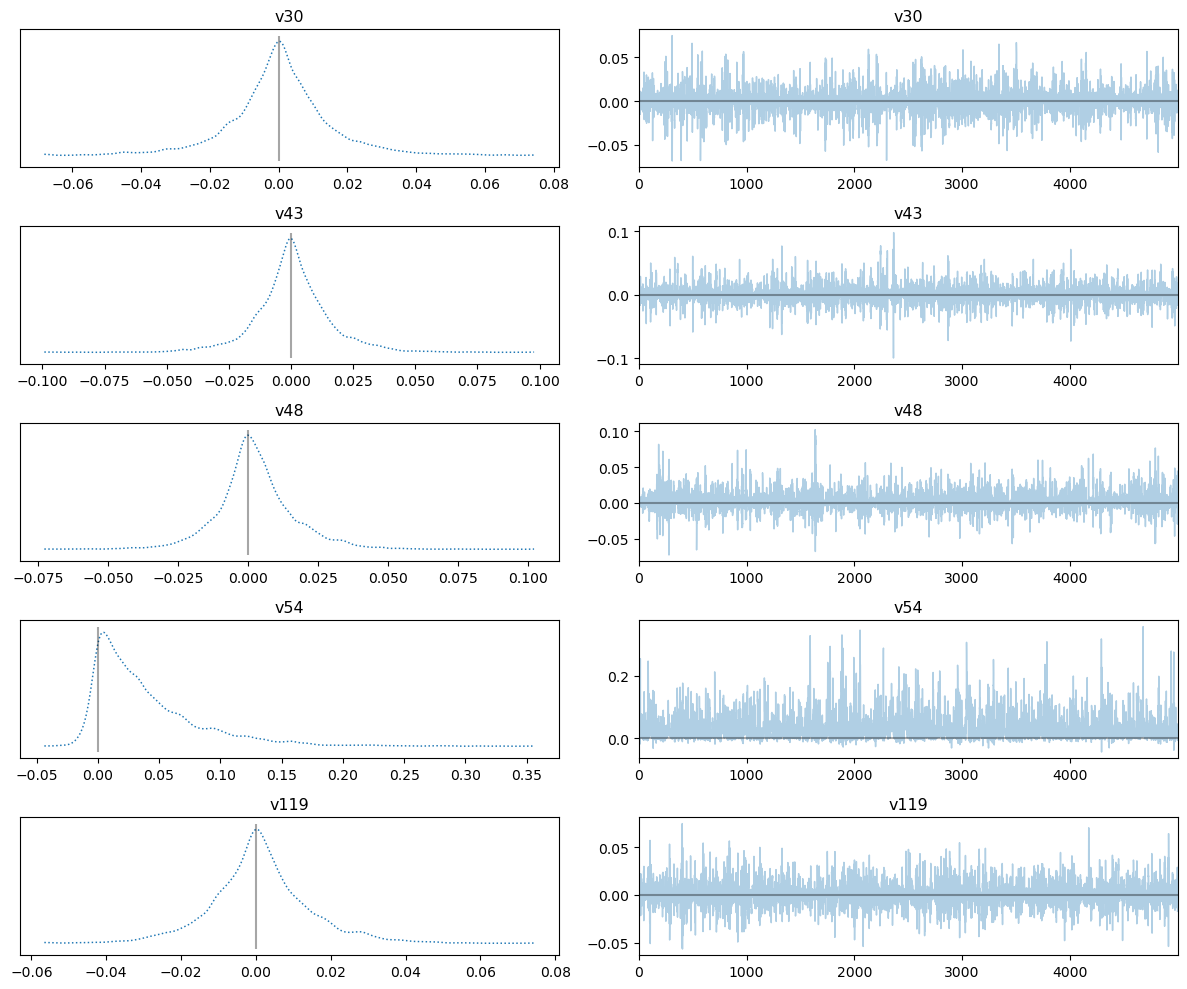

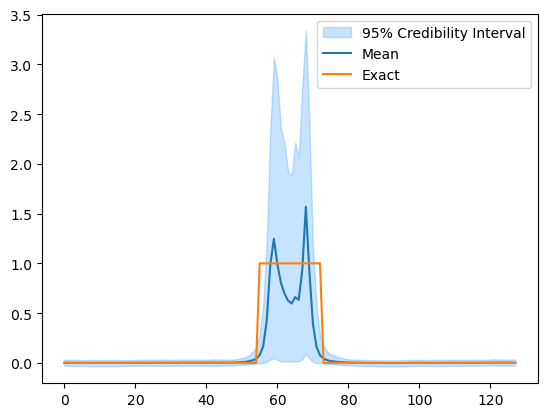

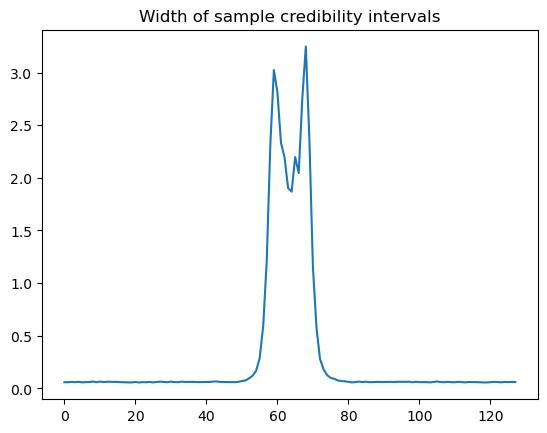

In [7]:
np.random.seed(0)

x = LaplaceSmoothed(location = np.zeros(n), scale=1e-2, beta=1e-6)

y = Gaussian(A@x, cov= noise_std**2)

x_y = JointDistribution(x, y)
p = x_y(y=y_data)
nuts_sampler = cuqi.sampler.NUTS(p)
nuts_samples = nuts_sampler.sample(5000, 3000)

nuts_samples.plot_trace(exact=info.exactSolution)

plt.figure()
nuts_samples.plot_ci(exact=info.exactSolution)

plt.figure()
nuts_samples.plot_ci_width()


We see that the posterior mean is driven to zero at most of the locations, and the uncertainty there is very small. This shows the effectiveness of using a Laplace prior in for such a signal.

To conclude, we have customed a smoothed Laplace distribution which is equipped with a `gradient` method such that a gradient-based sampling strategy can be applied. The implemented smoothed Laplace distribution is first verified in terms of functions to evaluted `logpdf` and `gradient` and also the histgram of drawn samples. Then it is applied in a deconvolution problem with the NUTS sampler, which would be impossible with the classic Laplace distribution.

We note that ideally the scale of the prior should be learned from the data. This can be done by using the Gibbs sampling method though it is not explored in this notebook.